This notebook is structures into several different parts:
1. Load ERAI and CESM data. Engineer some new features (e.g. pressure gradients)
1. Identify the most important features using a global XGBoost model.
1. Train several monthly XGBoost models on ERAI and CESM data simultaneously with the most important features from the step before.
1. Create contrast observational, predicted ERAI, CESM-p, and CESM-f data.
1. Test the observed differences for statistical significance.
1. Make composite plots for ERAI and CESM data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
from sklearn.model_selection import GridSearchCV
import os

# Custom functions
from plot_mean_foehn_conditions import plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import *
from model_training import *

# Import constants from constants.py file in directory above
import sys
sys.path.append("..")
from constants import *

# Define plotting style
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

--- Avaliable variables ---
Base directory: BASE_DIR
Month names: MONTH_NAMES
Bounding box coordinates: LON_MIN, LON_MAX, LAT_MIN, LAT_MAX
ERAI coordinates: LONS_ERA, LATS_ERA
CESM coordinates: LONS_CESM, LATS_CESM
CESM slice: INDEX_CESM
CESM coordinates for plotting (string): LONS_CESM_STRING, LATS_CESM_STRING


# Read ERA data

In [3]:
df_ERA_raw = pd.read_csv(os.path.join(BASE_DIR, "data", "MeteorologicalData", "ERAI_data.csv.gz"), parse_dates=["date"])

In [4]:
df_ERA = df_ERA_raw.copy() # Keep copy of original data

# Load CESM data 

In [5]:
df_CESMp = load_CESM(os.path.join(BASE_DIR, "data", "MeteorologicalData", "CESM_present_day.csv.gz"), LATS_CESM_STRING=LATS_CESM_STRING, LONS_CESM_STRING=LONS_CESM_STRING)
CESMp_features = set(df_CESMp.columns)

In [6]:
df_CESMf = load_CESM(os.path.join(BASE_DIR, "data", "MeteorologicalData", "CESM_future_day.csv.gz"), LATS_CESM_STRING=LATS_CESM_STRING, LONS_CESM_STRING=LONS_CESM_STRING)
CESMf_features = set(df_CESMf.columns)

# Use only features which are also in CESM and which are not in the Alps

In [7]:
# Only allow features which also exist in CESM
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
df_ERA = df_ERA[intersecting_features]

In [8]:
# Drop features which are within the Alps (since we want to classify synoptic situation)
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)
intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)
df_ERA.drop(intersecting_features, axis=1, inplace=True)
print(df_ERA.shape)

(57952, 1099)


# Calculate derived variables in ERAI

In [9]:
# Create potential temperature features
df_PHIT_900 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+900"))+273.15, p=900.0).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+850"))+273.15, p=850.0).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+700"))+273.15, p=700.0).add_prefix("PHI")
df_ERA = pd.concat([df_ERA, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

In [10]:
# Sealevel pressure differences
df_SLP_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="SLP", pressure_levels=["sealevel"])

# Geopotential height differences
df_Z_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="Z", pressure_levels=["850", "700"])

# Potential temperature differences
df_PHIT_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="PHIT", pressure_levels=["850"])

# Calculate stability
df_stability = calculate_stability(df_ERA, lats=LATS_CESM_STRING, lons=LONS_CESM_STRING)

# Filter wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [11]:
# Concat everything
df_ERA = pd.concat([df_ERA["date"], 
                     df_SLP_diff, 
                     df_Z_diff, 
                     df_PHIT_diff, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Merge in foehn data at specified location

In [12]:
# Specify location of interest
location="LUG"
foehn_type={"ALT": "SouthFoehn", "LUG": "NorthFoehn"}

In [13]:
# Read foehn preprocessed foehn data from this location
df_foehn_raw = pd.read_csv(os.path.join(BASE_DIR, "data", "FoehnData", f"{location}_foehn.csv"), parse_dates=["date"])
df_foehn_raw.dropna(inplace=True, how="any", axis=0)

In [14]:
# Merge ERAI and foehn data
df_ERA_all_features = pd.merge(df_foehn_raw, df_ERA, on="date", how="inner")

# Train Model on full data

In [15]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [16]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

Started
Best threshold: 0.8997067213058472
[[13585   181]
 [  181   589]]
Accuracy: 0.9750963126031921
Precision: 0.7649350649350649
Recall: 0.7649350649350649
ROC-AUC: 0.9892102884765968
Log-Loss: 0.10299481433304883


feature_name  importance
0                 diff_Z_4570_1375_850_Z_4664_375_850    0.397992
1   diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel    0.070325
2   diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel    0.031019
3           diff_PHIT_4476_875_850_PHIT_4853_1000_850    0.029693
4   diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel    0.028117
5                 diff_Z_4382_1000_700_Z_4664_375_700    0.026014
6   diff_SLP_4476_1375_sealevel_SLP_4853_875_sealevel    0.023803
7   diff_SLP_4476_1250_sealevel_SLP_4853_875_sealevel    0.014157
8                               DELTAPHI_4947_750_700    0.010696
9                                     V_4476_1000_700    0.010125
10                             DELTAPHI_4853_1000_850    0.009560
11                diff_Z_4476_1500_850_Z_4570_375_850    0.009421
12                diff_Z_4476_1375_850_Z_4664_375_850    0.008822
13  diff_SLP_4382_875_sealevel_SLP_4853_1000_sealevel    0.008073
14  diff_SLP_4664_1375_sealevel_SLP_4853_1000_seal...    0.007917
15                diff_Z_4476_1500_850_Z_4476_625_850    0.007562
16               diff_Z_4853_1000_850_Z_4853_1375_850    0.007189
17                diff_Z_4287_500_850_Z_4476_1375_850    0.006744
18                 diff_Z_4853_750_850_Z_4947_875_850    0.006706
19                 diff_Z_4382_250_850_Z_4947_750_850    0.006106
20                diff_Z_4287_250_850_Z_4947_1250_850    0.005708
21                diff_Z_4476_1125_850_Z_4570_375_850    0.005288
22                diff_Z_4287_500_850_Z_4476_1250_850    0.005075
23          diff_PHIT_4476_875_850_PHIT_4853_1125_850    0.004875
24                  diff_Z_4382_0_700_Z_4947_1375_700    0.004864
25                 diff_Z_4476_625_850_Z_4476_875_850    0.003975
26                diff_Z_4476_1250_850_Z_4664_375_850    0.003968
27                 diff_Z_4382_625_850_Z_4476_625_850    0.003843
28                diff_Z_4287_500_850_Z_4476_1125_850    0.003182
29  diff_SLP_4759_1375_sealevel_SLP_4853_1125_seal...    0.003154
30                diff_Z_4476_1125_850_Z_4476_625_850    0.002826
31                 diff_Z_4382_875_850_Z_4664_375_850    0.002751
32                diff_Z_4476_1000_850_Z_4570_375_850    0.002711
33  diff_SLP_4382_750_sealevel_SLP_4853_1125_sealevel    0.002623
34                              DELTAPHI_4382_750_700    0.002463
35   diff_SLP_4476_875_sealevel_SLP_4853_875_sealevel    0.002339
36  diff_SLP_4476_750_sealevel_SLP_4853_1000_sealevel    0.002308
37                 diff_Z_4476_750_850_Z_4476_875_850    0.002255
38                diff_Z_4476_1125_850_Z_4853_750_850    0.002252
39               diff_Z_4759_1375_850_Z_4853_1000_850    0.002210
40   diff_SLP_4476_750_sealevel_SLP_4853_875_sealevel    0.002065
41                diff_Z_4287_750_700_Z_4476_1250_700    0.002023
42  diff_SLP_4476_1500_sealevel_SLP_4853_875_sealevel    0.001928
43          diff_PHIT_4476_750_850_PHIT_4853_1250_850    0.001901
44                 diff_Z_4476_500_850_Z_4476_875_850    0.001821
45                diff_Z_4476_1125_850_Z_4853_875_850    0.001807
46               diff_Z_4853_1125_700_Z_4853_1500_700    0.001800
47                                     U_4476_750_850    0.001709
48   diff_SLP_4853_250_sealevel_SLP_4853_750_sealevel    0.001671
49                                     V_4382_500_700    0.001617

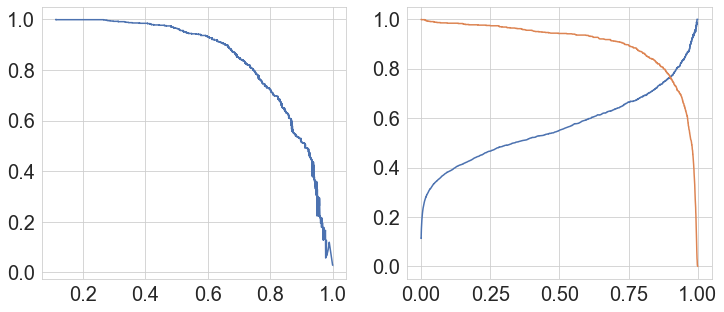

In [1056]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=1.0,
                    reg_lambda=10.0,
                    n_estimators=200,
                    verbosity=0,
                    nthread=25,
                    scale_pos_weight=20.0,
                    base_score=0.05,
                    seed=1337,
                    missing=None,
                  )

params = {"n_estimators": [50,100,200], 'max_depth': [4,5], 'learning_rate': [0.1, 0.2], "reg_alpha": [1], "reg_lambda":[10,100]}
df_ERA_feature_importances = fit_model_and_obtain_importances(model_xg, df_ERA_all_features, feature_names, train_mask, test_mask, with_CV=False, parameters_CV=params)

# Reduce dataframe to most important features (use this as restart files after training large models)

In [1226]:
# Write most important 250 features to text file
feature_names_reduced = list(df_ERA_feature_importances.loc[:250, "feature_name"])
with open(os.path.join(BASE_DIR, "data", f"reduced_features_{foehn_type[location]}.txt"), "w") as f:
    for feature in feature_names_reduced:
        f.write('%s\n' % feature)

In [17]:
# Read most important 250 features from text file
# Only run this cell when large model has been trained
feature_names_reduced = []
with open(os.path.join(BASE_DIR, "data", f"reduced_features_{foehn_type[location]}.txt"), 'r') as f:
    for line in f:
        feature_names_reduced.append(line[:-1])

# Build dataframe from reduced features
df_ERA_reduced_features = df_ERA_all_features.loc[:,feature_names_reduced]
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [18]:
# Fit quantile transformer to train set
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

# Transform train and test set
df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_ERA_reduced_features.index)

# Append date and foehn column
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [19]:
# Create features from large CESM files which are used by the simplified model
df_CESMp_reduced_features = generate_reduced_features_on_CESM(feature_to_generate = feature_names_reduced, df_CESM = df_CESMp)
df_CESMf_reduced_features = generate_reduced_features_on_CESM(feature_to_generate = feature_names_reduced, df_CESM = df_CESMf)

In [20]:
# Transform CESM features to quantiles. 
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced]) # Fit transformer to present day data

# Apply transformation to present and future day data
df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_CESMp_reduced_features.index)
df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_CESMf_reduced_features.index)

# Append date and ensemble member again
df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]
df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [21]:
# Train constraint model (parameters were found after hyperparameter optimization in a seperate experiment).
if location=="ALT":
    params = {'max_depth': 4, 'learning_rate': 0.2, "reg_alpha":1, "reg_lambda":20, "n_jobs": 25,"verbosity":1, "seed": 0}
    initial_boosting_rounds = 10
    lambda_ = 60000
elif location=="LUG": # {'max_depth': 4, 'learning_rate': 0.25, "reg_alpha":1, "reg_lambda":20, "n_jobs": 25,"verbosity":1, "seed": 0}
    params = {'max_depth': 4, 'learning_rate': 0.25, "reg_alpha":1, "reg_lambda":20, "n_jobs": 45,"verbosity":1, "seed": 0}
    initial_boosting_rounds = 20
    lambda_ = 90000

constrained_xgboost = ConstrainedXGBoost(df_ERA = df_ERA_reduced_features_scaled, 
                                         df_CESMp = df_CESMp_reduced_features_scaled,
                                         features = feature_names_reduced, 
                                         train_mask = train_mask, 
                                         test_mask = test_mask, 
                                         params = params, 
                                         initial_boosting_rounds = initial_boosting_rounds,
                                         lambda_= lambda_) 
for month in range(1,12+1):
    print(MONTH_NAMES[month-1])
    constrained_xgboost.fit_for_month(month)
    constrained_xgboost.evaluate_for_month(month)

Loading data ...
Fitting global model ...
Storing global model ...
Model ready to use ...
Jan
Best threshold: 0.44580721855163574
Precision: 0.7076923076923077
Recall: 0.7076923076923077
[[1155   19]
 [  19   46]]
Feb
Best threshold: 0.5343574285507202
Precision: 0.7156862745098039
Recall: 0.7156862745098039
[[1001   29]
 [  29   73]]
Mar
Best threshold: 0.5659318566322327
Precision: 0.7559523809523809
Recall: 0.7559523809523809
[[1031   41]
 [  41  127]]
Apr
Best threshold: 0.5475097894668579
Precision: 0.7247706422018348
Recall: 0.7247706422018348
[[1061   30]
 [  30   79]]
May
Best threshold: 0.5189180970191956
Precision: 0.7916666666666666
Recall: 0.7916666666666666
[[1153   15]
 [  15   57]]
Jun
Best threshold: 0.49254077672958374
Precision: 0.7213114754098361
Recall: 0.7213114754098362
[[1122   17]
 [  17   44]]
Jul
Best threshold: 0.37801724672317505
Precision: 0.6842105263157895
Recall: 0.6842105263157895
[[1140   24]
 [  24   52]]
Aug
Best threshold: 0.5291157960891724
Precisi

[[13400.   269.]
 [  269.   673.]]
Accuracy: 0.9631784272123742
Precision: 0.7144373673036093
Recall: 0.7144373673036093
ROC-AUC: 0.9794579114114274
Log-Loss: 0.09446512446736809
Saved figure at: /atmosdyn2/chmony/develop/FoehnDevelopment/figures/monthly_scores_ERAI_NorthFoehn.pdf


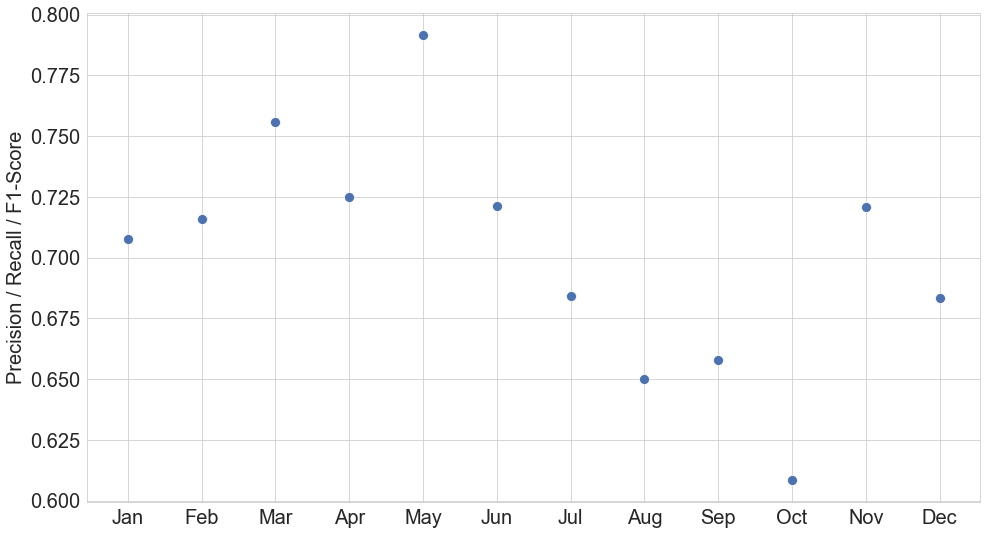

In [22]:
# Evaluate model for all months on test set
tcm = constrained_xgboost.total_confusion_matrix

# Print various test set metrics
print(tcm)
print(f'Accuracy: {(tcm[1,1]+tcm[0,0])/tcm[:,:].sum()}')
print(f'Precision: {tcm[1,1]/tcm[:,1].sum()}')
print(f'Recall: {tcm[1,1]/tcm[1,:].sum()}')
print(f'ROC-AUC: {roc_auc_score(constrained_xgboost.df_ERA.loc[test_mask, "Foehn"], constrained_xgboost.df_ERA.loc[test_mask, "prediction_proba"])}')
print(f'Log-Loss: {log_loss(constrained_xgboost.df_ERA.loc[test_mask, "Foehn"], constrained_xgboost.df_ERA.loc[test_mask, "prediction_proba"])}')

# Plot precision, recall, and f1 scores each month
sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.precision_scores.values()), s=100, alpha=1, marker="o")
# sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.recall_scores.values()), s=100, alpha=1)
# sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.f1_scores.values()), s=100, alpha=1)
plt.ylabel("Precision / Recall / F1-Score")

save_figure(f"monthly_scores_ERAI_{foehn_type[location]}")

# Predict on CESMp and CESMf

In [284]:
df_ERA_reduced_features_scaled = constrained_xgboost.df_ERA
df_CESMp_reduced_features_scaled = constrained_xgboost.predict_for_all_months(df_CESMp_reduced_features_scaled)
df_CESMf_reduced_features_scaled = constrained_xgboost.predict_for_all_months(df_CESMf_reduced_features_scaled)

# Concenate all dataframes

In [285]:
df_foehn_ERA_CESMp_CESMf = create_stacked_dataframe(df_ERA_reduced_features_scaled, df_CESMp_reduced_features_scaled, df_CESMf_reduced_features_scaled)

In [286]:
# Save predictions
df_foehn_ERA_CESMp_CESMf.to_csv(os.path.join(BASE_DIR, "data", f"final_predictions_{foehn_type[location]}.csv"), index=False)

# Read predictions again

In [78]:
# Specify location of interest
location="LUG"
foehn_type={"ALT": "SouthFoehn", "LUG": "NorthFoehn"}

df_foehn_ERA_CESMp_CESMf = pd.read_csv(os.path.join(BASE_DIR, "data", f"final_predictions_{foehn_type[location]}.csv"), parse_dates=["date"])

In [79]:
# Group dataframe by dataset and calculate predictions mean
df_foehn_ERA_CESMp_CESMf[["dataset", "prediction"]].groupby(["dataset"], axis=0, as_index=False).mean()

dataset  prediction
0           CESMf    0.059008
1           CESMp    0.059818
2             ERA    0.065782
3  observed_foehn    0.065800

95% quantile (CESM-p ensembles):  0.0673013698630137


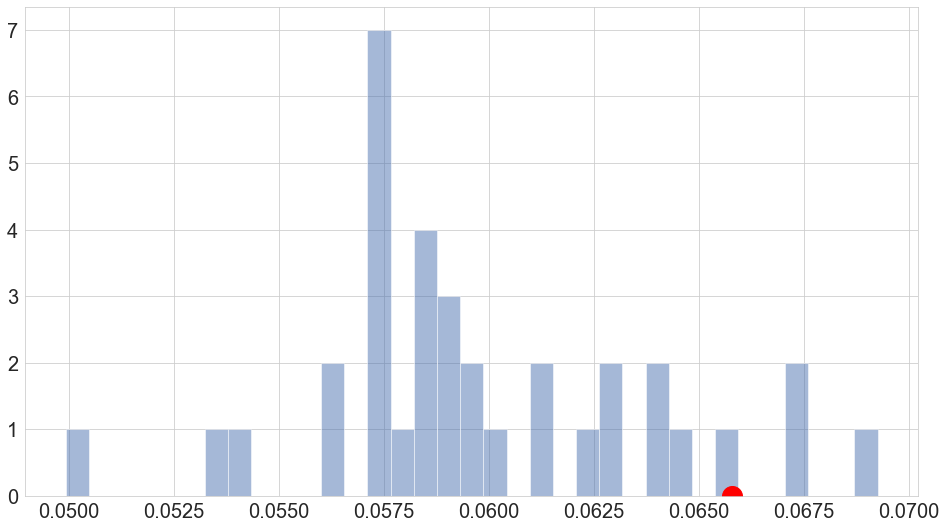

In [80]:
# Group dataframe by dataset & ensemble and calculate predictions mean
df_absolute_test = df_foehn_ERA_CESMp_CESMf[["dataset", "ensemble", "year", "prediction"]].groupby(["dataset", "ensemble"], axis=0, as_index=False).mean()
print("95% quantile (CESM-p ensembles): ", df_absolute_test.loc[df_absolute_test["dataset"]=="CESMp", "prediction"].quantile(0.95))
df_absolute_test.loc[df_absolute_test["dataset"]=="CESMp", "prediction"].hist(bins=35, alpha=0.5)
plt.plot(df_absolute_test.loc[df_absolute_test["dataset"]=="ERA", "prediction"],0,  "ro", markersize=20)  # Plot ERAI mean

In [81]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean 
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble",  "year", "month"], axis=0, as_index=False).mean()
df_monthly_mean_testset = df_foehn_ERA_CESMp_CESMf.query("(year >1990 & year <2001) | year > 2080")[["year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()
df_decadal_mean_testset = df_monthly_mean_testset.groupby(["dataset", "ensemble", "month"], axis=0, as_index=False).mean()

In [82]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
#test_mask_final_plot = ((1990<df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090<df_monthly_mean["year"])
#df_monthly_mean_testset = df_monthly_mean

# Third statistical test

In [83]:
# Loop over all months to test for differences in distribution between CESMp and CESMf
MONTH_NAMES_SIG = MONTH_NAMES.copy()
for month_test in range(1, 12+1):
    df_CESMp_month = df_decadal_mean_testset.loc[(df_decadal_mean_testset["dataset"]=="CESMp") & (df_decadal_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_decadal_mean_testset.loc[(df_decadal_mean_testset["dataset"]=="CESMf") & (df_decadal_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ranksums(df_CESMp_month["prediction"], df_CESMf_month["prediction"])  # Conduct wilcoxon ranksum test
    
    # Print results of statistical test (0.05/12 = 0.0042 is due to Bonferroni correction)
    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.0042)) 
    if p<0.0042:
        MONTH_NAMES_SIG[month_test-1] = MONTH_NAMES_SIG[month_test-1] + "*"
    
    MONTH_NAMES_SIG[month_test-1] += "\n(" + str(round(p,3)) + ")"
    
    # LaTeX formatted table (just uncomment)
    #print(f"{MONTH_NAMES[month_test-1]} & {np.round(p,5)} & {'Yes' if (p<0.0042) else 'No'} \\\\ \hline" )
print(MONTH_NAMES_SIG)

Jan	0.00096	True
Feb	0.061	False
Mar	0.0519	False
Apr	0.82797	False
May	0.00134	True
Jun	0.83714	False
Jul	0.0	True
Aug	0.00028	True
Sep	0.0	True
Oct	0.14045	False
Nov	0.22634	False
Dec	0.04274	False
['Jan*\n(0.001)', 'Feb\n(0.061)', 'Mar\n(0.052)', 'Apr\n(0.828)', 'May*\n(0.001)', 'Jun\n(0.837)', 'Jul*\n(0.0)', 'Aug*\n(0.0)', 'Sep*\n(0.0)', 'Oct\n(0.14)', 'Nov\n(0.226)', 'Dec\n(0.043)']


# Create Plots

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/final_comparison_NorthFoehn.pdf


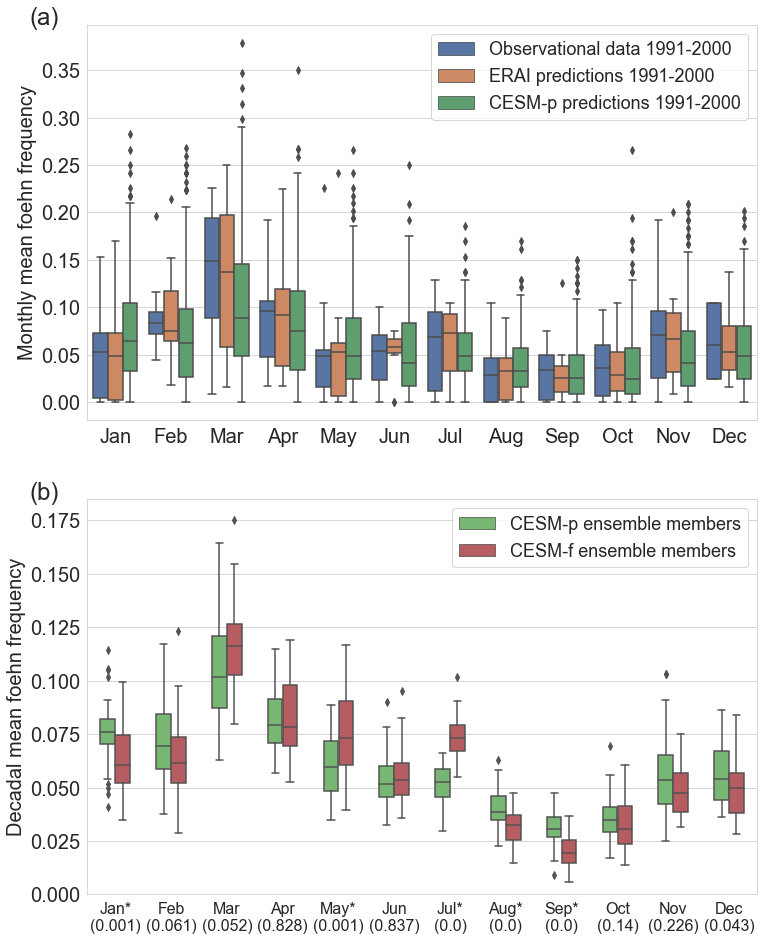

In [84]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(12,16))
plt.subplot(211)
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"] != "CESMf"), :], width=0.8, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp"])
fig.set_xticklabels(MONTH_NAMES)
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")
fig.text(-1.53,fig.get_ylim()[1], "(a)", fontsize=24)
y_lims = fig.get_ylim()

handles, labels = fig.get_legend_handles_labels()
labels = ["Observational data 1991-2000", "ERAI predictions 1991-2000", "CESM-p predictions 1991-2000" ]
fig.legend(handles, labels, fontsize=18)

plt.subplot(212)
fig = sns.boxplot(x="month", y="prediction", data=df_decadal_mean_testset.loc[df_decadal_mean_testset["dataset"].isin(["CESMp", "CESMf"]), :], width = 0.53333333, hue="dataset", hue_order=["CESMp", "CESMf"], palette={"CESMp": np.array(sns.color_palette()[2]) + (0.1,0.1,0), "CESMf": sns.color_palette()[3]} )
fig.set_xticklabels(MONTH_NAMES_SIG, size=16)
plt.xlabel("")
plt.ylabel("Decadal mean foehn frequency")
plt.ylim([0,0.185])
fig.text(-1.53,fig.get_ylim()[1], "(b)", fontsize=24, ha="left")


handles, labels = fig.get_legend_handles_labels()
labels = ["CESM-p ensemble members", "CESM-f ensemble members" ]
fig.legend(handles, labels, fontsize=18)
save_figure(f"final_comparison_{foehn_type[location]}")

# Second statistical test

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/statistical_test_ERAI_CESMp_SouthFoehn.pdf


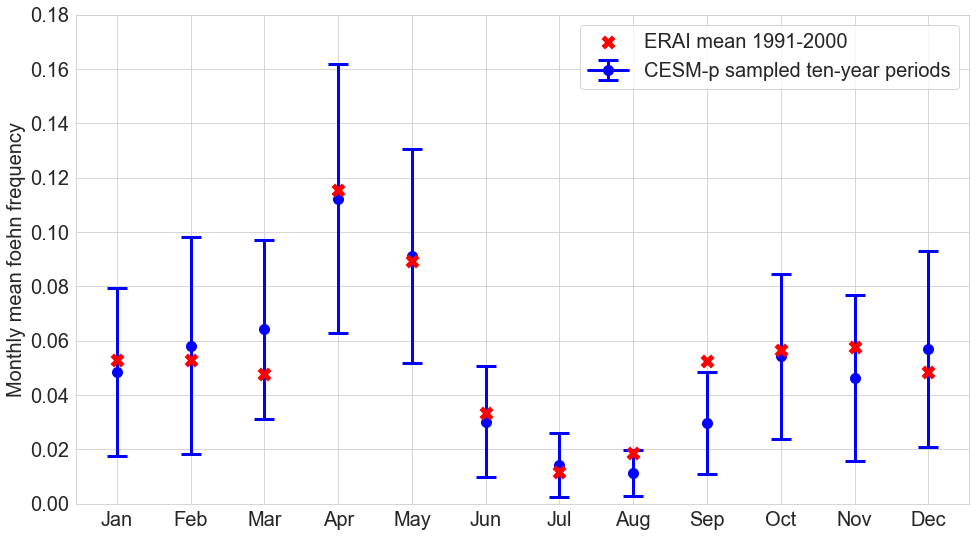

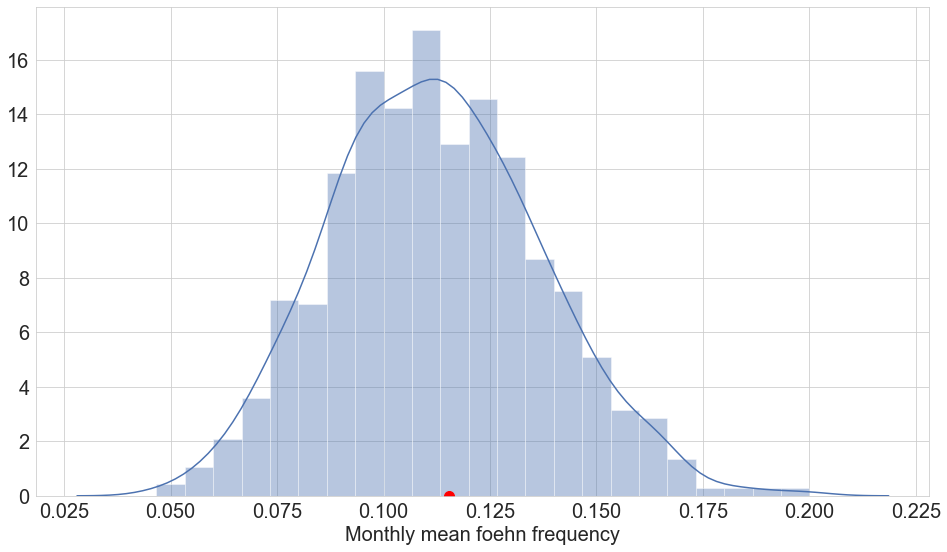

In [383]:
ax = plt.axes()

# Loop over all months
for month_test in range(1, 12+1):
    
    # Draw monthly foehn means for a given month for potential CESM periods (1991-2000)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(1000):  # Draw 1000 potential realizations
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))  # Randomly pick a month out of the 35 ensemble members
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
    
    # Plot CESM distribution (mean and second standart deviation)
    plt.figure(1)
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 2*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    
    # Plot ERAI mean
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)
    
    # Plot histogram of CESM distribution for a selected month
    if month_test==4:
        plt.figure()
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
        plt.xlabel("Monthly mean foehn frequency")
    
    if month_test==1:  # To make plot prettier
        legend = ax.legend(["ERAI mean 1991-2000", "CESM-p sampled ten-year periods"])

ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("")
ax.set_ylabel("Monthly mean foehn frequency")
ax.set_ylim((0,0.18))

save_figure(f"statistical_test_ERAI_CESMp_{foehn_type[location]}")

# Plot ensemble deviation

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/final_comparison_ensembles_NorthFoehn.pdf


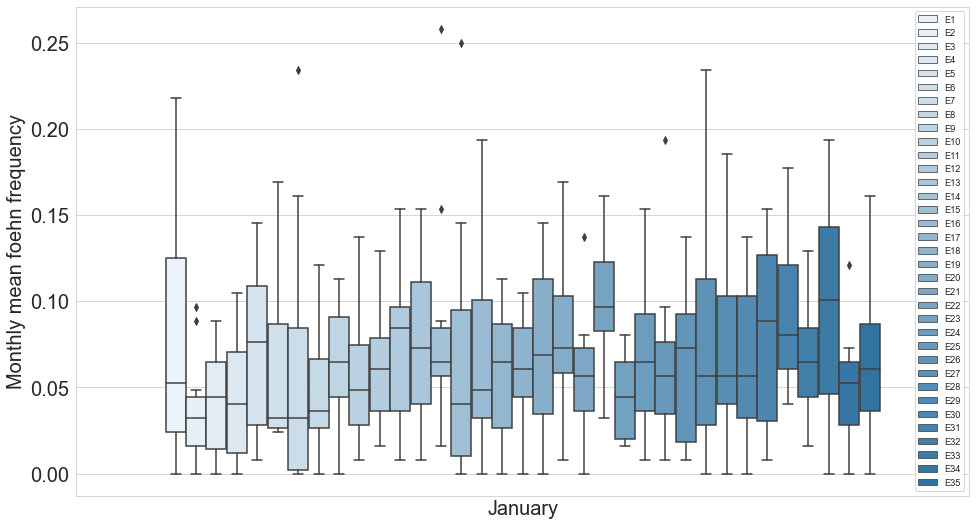

In [92]:
# Create a plot with all ensemble member distributions (10 years) for an given month
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")
ax.set(xticks=[])
ax.set_xlabel("January")
ax.set_ylabel("Monthly mean foehn frequency")
ax.legend(fontsize=9.25)
save_figure(f"final_comparison_ensembles_{foehn_type[location]}")

# Plot composite maps

In [137]:
# Get original data and add potential temperatures
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()
df_PHIT_900 = calc_pot_temp(T=df_ERA_raw.filter(regex=("T_\w+900"))+273.15, p=900.0).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_ERA_raw.filter(regex=("T_\w+850"))+273.15, p=850.0).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_ERA_raw.filter(regex=("T_\w+700"))+273.15, p=700.0).add_prefix("PHI")
df_ERA_raw_temp_adjusted = pd.concat([df_ERA_raw_temp_adjusted, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Calculate potential temperature (in Kelvin) and stability
temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns] + 273.15  # Make temperature columns in Kelvin
df_ERA_with_stability = pd.concat([df_ERA_raw_temp_adjusted, calculate_stability(df = df_ERA_raw_temp_adjusted, lats=LATS_CESM_STRING, lons=LONS_CESM_STRING)], axis=1)  # Add stability variables

# Merge with foehn values 
df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")

In [138]:
# Define variables to be plotted, their respective limits ad units for each station
variable = 'SLP'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "K",
        "DELTAPHI": "K",
        "U": "m/s"}

if location == "ALT":
    v_limits = {"SLP": [1002, 1023],
                "Z": [1360, 1570],
                "T": [3+273, 10.5+273],
                "DELTAPHI": [5,12],
                "U":[5,15]}
elif location == "LUG":
    v_limits = {"SLP": [1009, 1027.5],
                "Z": [1420, 1581],
                "T": [-4+273, 7.05+273],
                "DELTAPHI": [4, 14.05],
                "U":[5,15]}

SLP
Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/SLP_composite_NorthFoehn.pdf
Z
Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/Z_composite_NorthFoehn.pdf
T
Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/T_composite_NorthFoehn.pdf
DELTAPHI
Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/DELTAPHI_composite_NorthFoehn.pdf
U
Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/U_composite_NorthFoehn.pdf


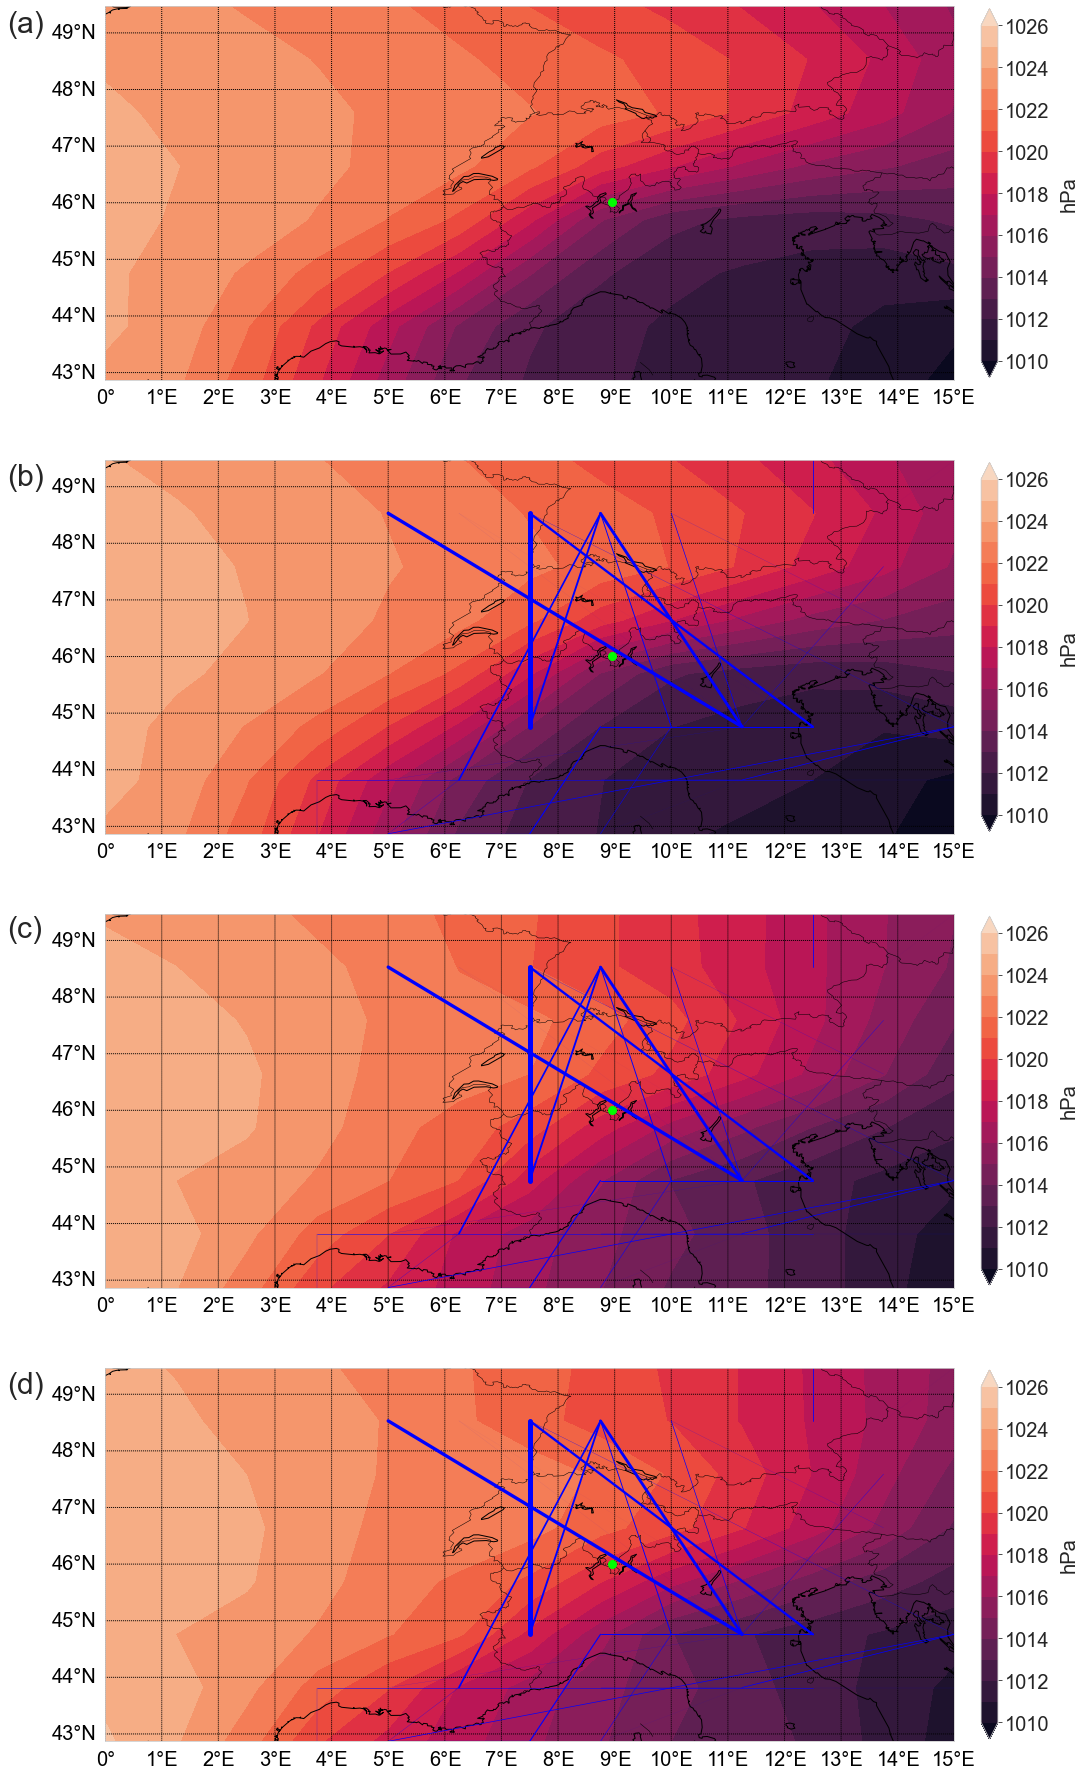

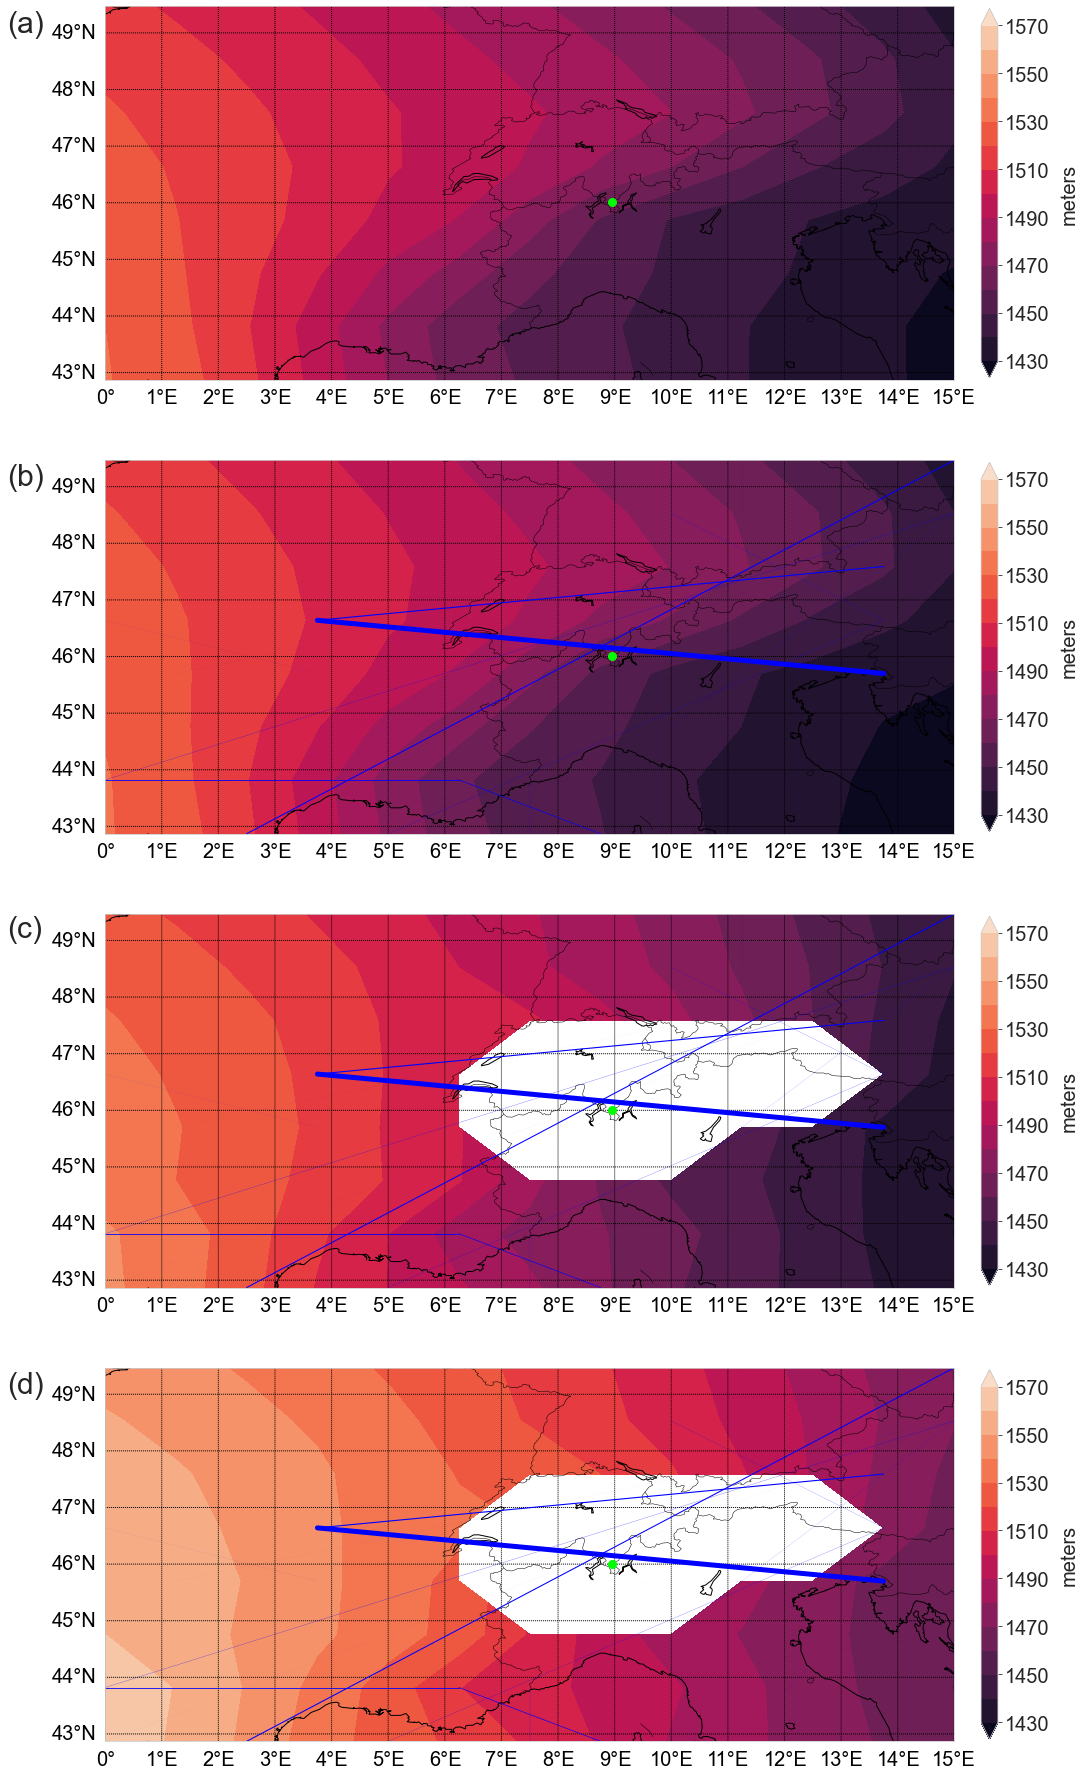

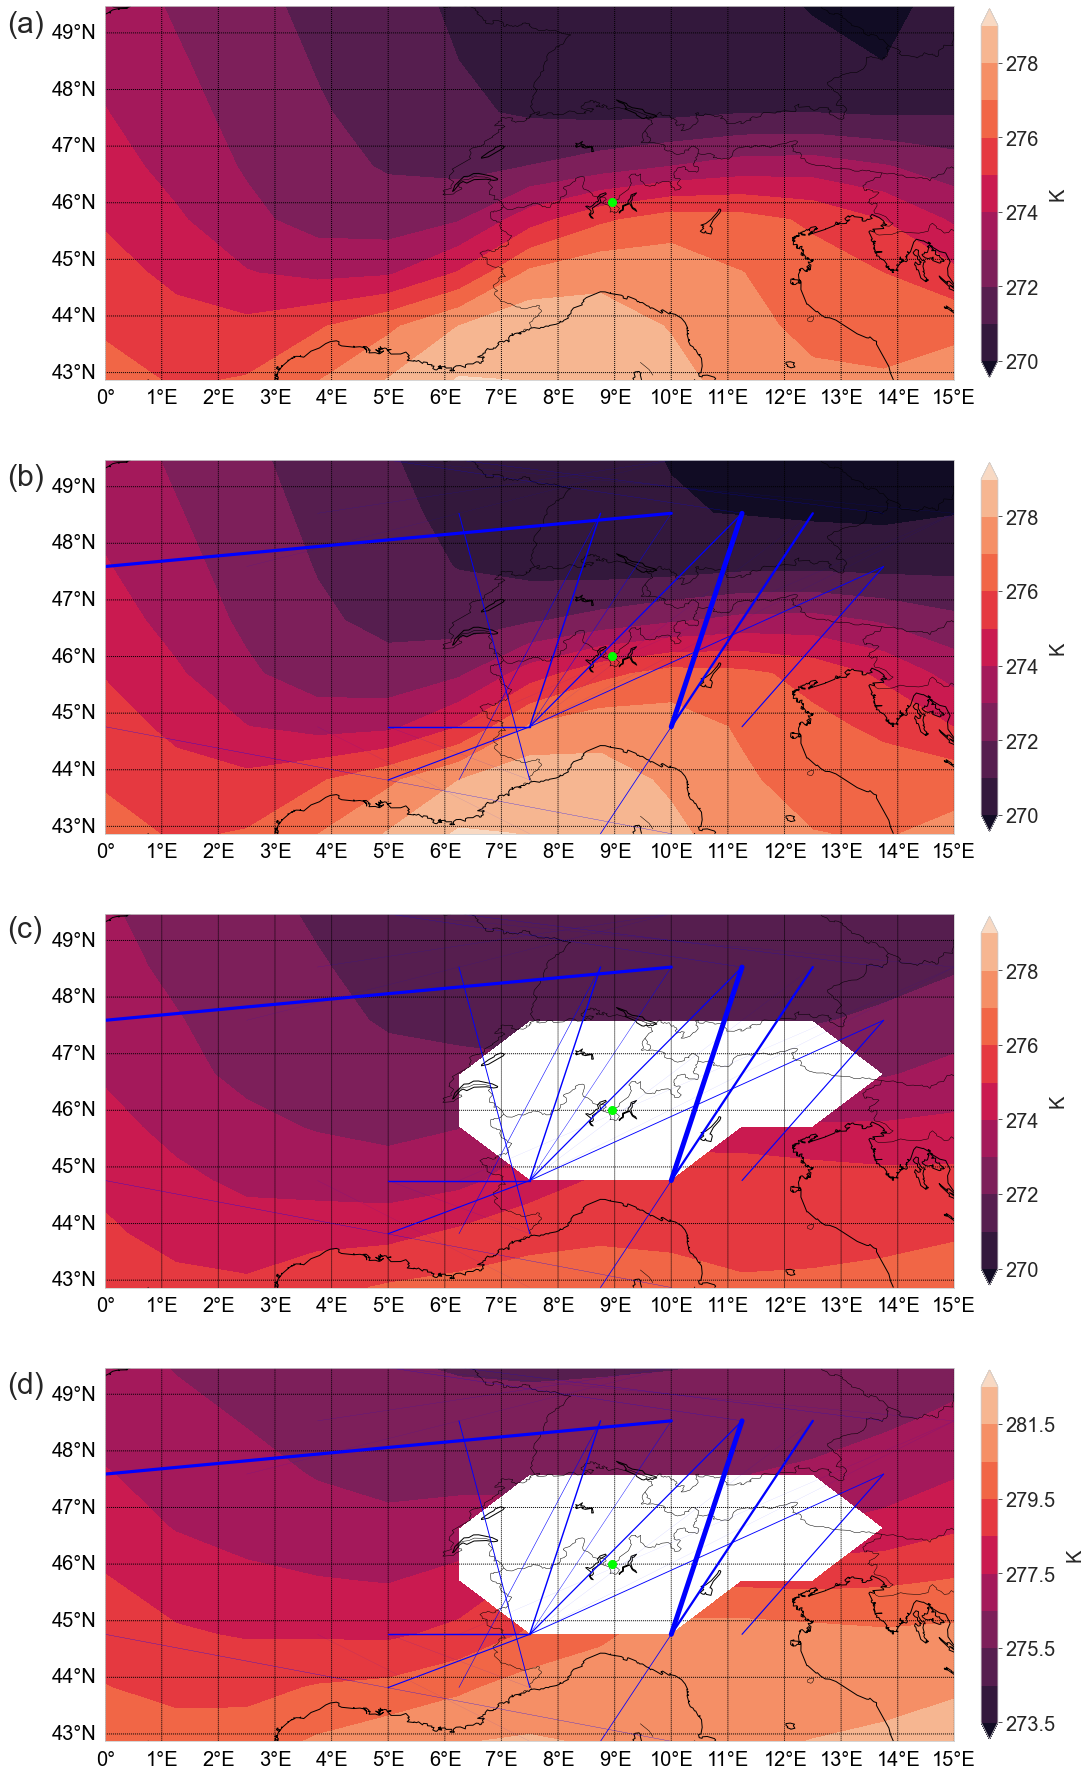

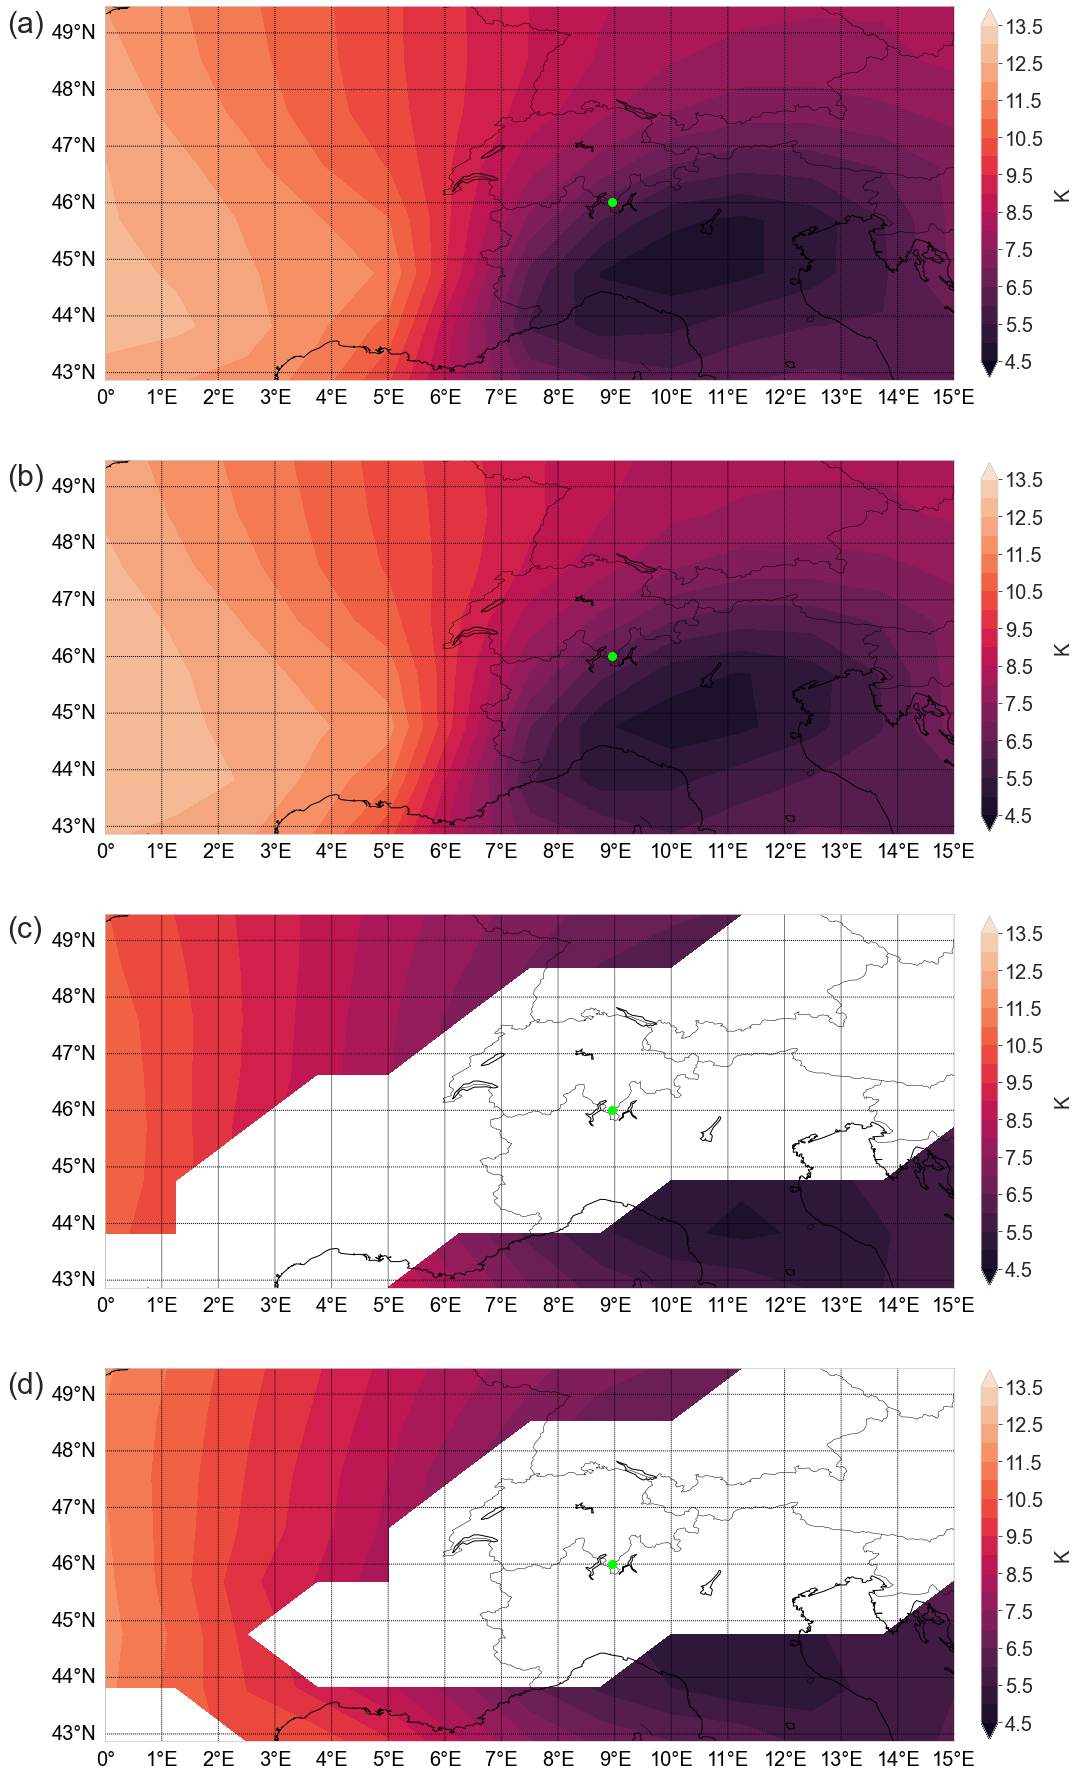

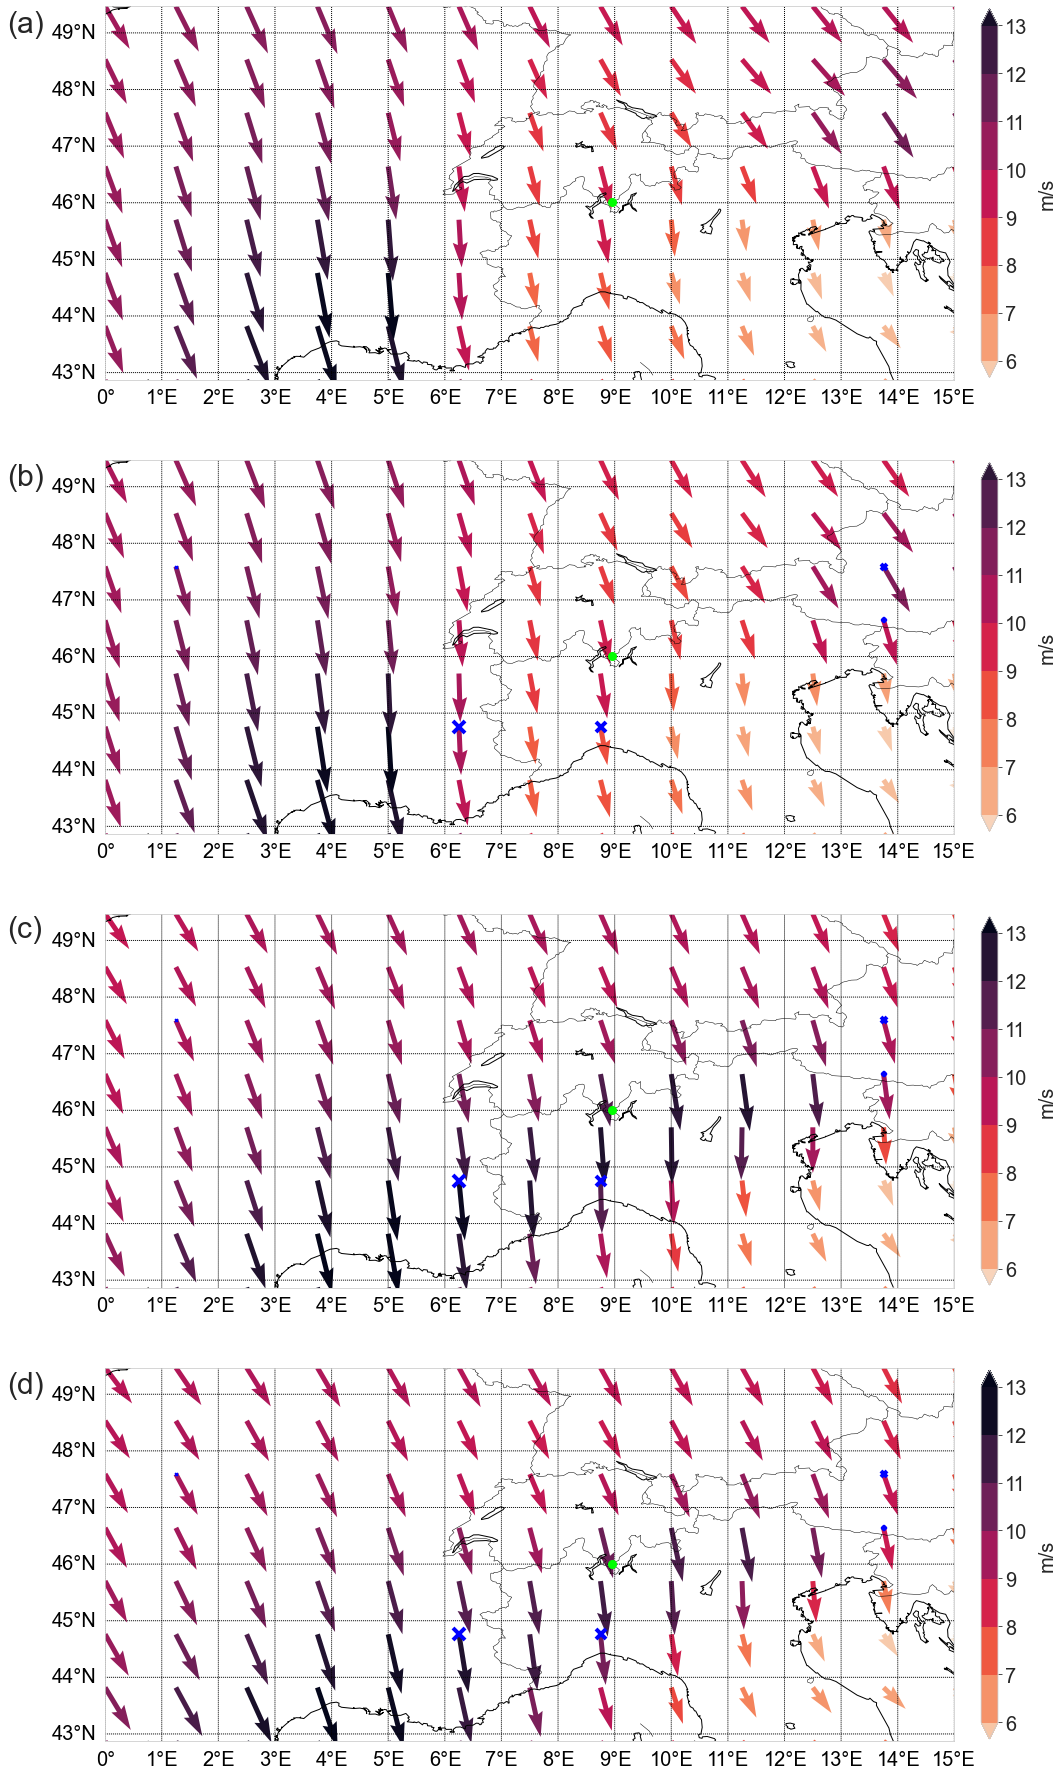

In [142]:
# Make composite plots
for variable in list(variable_lvl.keys()):
    print(variable)
    
    # Generate variable importance dataframe for specific variable
    df_importances = generate_coordinates_from_feature_label(constrained_xgboost.most_important_features, variable)
    # df_importances["importance"] = np.sqrt(df_importances["importance"])  # For visibility of lines
    
    # Set all keyword arguments for function calls below
    kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": pd.DataFrame(),
          "location": location}
    
    
    fig = plt.figure(figsize=(16, 4*8))
    
    # OBS data
    fig.add_subplot(411)
    fig.text(0.04,0.868, "(a)", size=30, ha="left")
    
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"OBS_{foehn_type[location]}", 
                                            df = df_ERA_with_stability.loc[test_mask,:], 
                                            foehn = df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                            )
    
    
    kwargs.update({"df_importances": df_importances})  # From now also plot importances
    
    # ERAI
    fig.add_subplot(412)
    fig.text(0.04,0.671, "(b)", size=30, ha="left")
    plot_mean_foehn_condition_for_one_model(**kwargs,
                                            model= f"ERA-Interim_{foehn_type[location]}",
                                            df = df_ERA_with_stability.loc[test_mask, :], 
                                            foehn = df_ERA_reduced_features_scaled.loc[test_mask, "prediction"], 
                                            )

    # CESM-p
    fig.add_subplot(413)
    fig.text(0.04,0.475, "(c)", size=30, ha="left")
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-present_{foehn_type[location]}", 
                                            df = df_CESMp.loc[:,:], 
                                            foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                            )
    # CESM-f
    fig.add_subplot(414)
    fig.text(0.04,0.277, "(d)", size=30, ha="left")
    if variable =="T":  # Shift upwards due to higher temperatures in future
        kwargs["vmin"] += 3.5
        kwargs["vmax"] += 3.5
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-future_{foehn_type[location]}",
                                            df = df_CESMf.loc[:,:], 
                                            foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                            )
    # Save figure
    save_figure(f"{variable}_composite_{foehn_type[location]}")

# Create false positive and false negative composite plots

In [143]:
df_ERA_reduced_features_scaled["false_positive"] = (df_ERA_reduced_features_scaled["prediction"]==1) & (df_ERA_reduced_features_scaled["Foehn"]==0)
df_ERA_reduced_features_scaled["false_negative"] = (df_ERA_reduced_features_scaled["prediction"]==0) & (df_ERA_reduced_features_scaled["Foehn"]==1)

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/SLP_composite_NorthFoehn_FP_FN.pdf


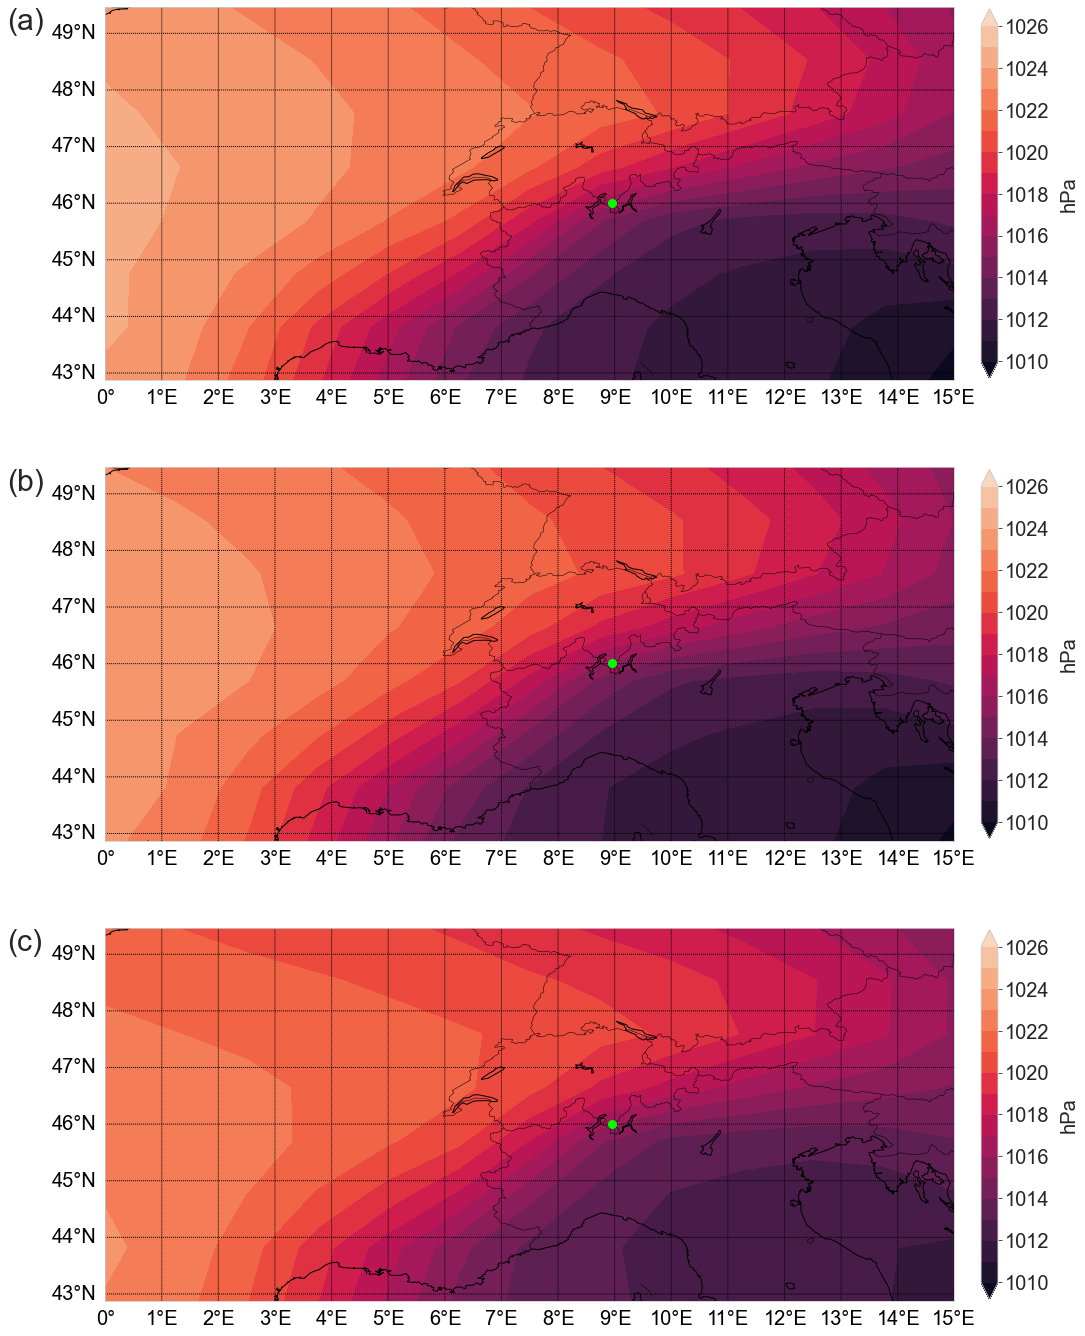

In [144]:
# Define variable of interest
variable="SLP"

# Set all keyword arguments for function calls below
kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": pd.DataFrame(),
          "location": location}

fig = plt.figure(figsize=(16, 3*8))

# OBS data (Foehn==1)
fig.add_subplot(311)
fig.text(0.04,0.864, "(a)", size=30, ha="left")
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                        )

# False positives
fig.add_subplot(312)
fig.text(0.04,0.597, "(b)", size=30, ha="left")
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "false_positive"], 
                                        )

# False negatives
fig.add_subplot(313)
fig.text(0.04,0.331, "(c)", size=30, ha="left")
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "false_negative"], 
                                        )

# Save figure
save_figure(f"{variable}_composite_{foehn_type[location]}_FP_FN")